In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis import rms 
from MDAnalysis.analysis import contacts
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
from MDAnalysis.analysis import distances 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import PillowWriter
import tikzplotlib

print("Using MDAnalysis version", mda.__version__)

import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')

Using MDAnalysis version 2.7.0


In [2]:
# Function to extract the number before the .dcd extension
def extract_number(file_path):
    match = re.search(r'step5_assembly\.(\d+)\.dcd', file_path)
    if match:
        return int(match.group(1))
    return -1  # Default case if no match is found (unlikely in this context)

# Analyzing MD Simulations of GlyA Membrane Protein using MDAnalysis

System: Glycophorin A (2KPF) in a pure POPC bilayer

In [3]:
os.chdir('c:\\Users\\Ron\\Desktop\\UIUC\\LabRotation1')
NoC_dir = os.path.join(os.getcwd(), 'namd_run_2kpf_NoC.5')
Cho_dir = os.path.join(os.getcwd(), 'namd_run_2kpf_Cho.1')
NoC_psf = os.path.join(NoC_dir, 'step5_assembly.psf')
Cho_psf = os.path.join(Cho_dir, 'step5_assembly.psf')
NoC_dcd = [os.path.join(NoC_dir, dcd) for dcd in os.listdir(NoC_dir) if dcd[-4::]=='.dcd']
Cho_dcd = [os.path.join(Cho_dir, dcd) for dcd in os.listdir(Cho_dir) if dcd[-4::]=='.dcd']

sorted_NoC_dcd = sorted(NoC_dcd, key=extract_number)
sorted_Cho_dcd = sorted(Cho_dcd, key=extract_number)

#Load universes
u_NoC = mda.Universe(NoC_psf, sorted_NoC_dcd)
u_Cho = mda.Universe(Cho_psf, sorted_Cho_dcd)
print(f'Loaded 2KPF System with no cholesterol has {len(u_NoC.atoms)} atoms and {len(u_NoC.trajectory)} frames')
print(f'Loaded 2KPF System with 30% cholesterol has {len(u_Cho.atoms)} atoms and {len(u_Cho.trajectory)} frames')

Loaded 2KPF System with no cholesterol has 36252 atoms and 80001 frames
Loaded 2KPF System with 30% cholesterol has 39421 atoms and 79990 frames


## Radius of Gyration and RMSD

In [4]:
# Calculate radius of gyration for all protein atoms

N=7500 #number of frames
rgyr = [[], []]
for f in range(N):
    u_NoC.trajectory[f]
    u_Cho.trajectory[f]
    rgyr[0].append(u_NoC.select_atoms('protein').radius_of_gyration())
    rgyr[1].append(u_Cho.select_atoms('protein').radius_of_gyration())

rgyr = pd.DataFrame(np.array(rgyr).T, columns =['No Cholesterol', '30% Cholesterol'])

Text(0.5, 0, 'ps')

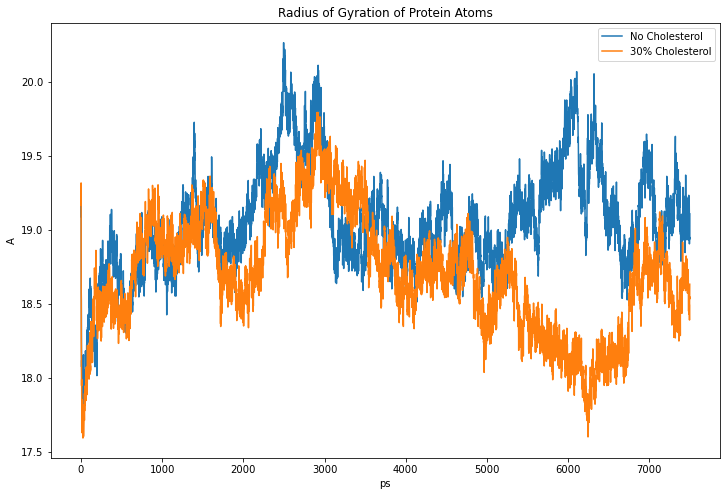

In [5]:
plt.figure(figsize=(12,8))
plt.plot(rgyr, label=list(rgyr.columns))
plt.title('Radius of Gyration of Protein Atoms')
plt.legend(loc='best')
plt.ylabel('A')
plt.xlabel('ps')

# tikzplotlib.save('Radius_of_Gyration.tikz')

In [6]:
# Run RMSD for CA, backbone, and protein (no cholesterol)
N=7500
u_NoC.trajectory[0] #set to first frame
rmsd_analysis_NoC = rms.RMSD(u_NoC, select='backbone', groupselections=['segid PROA', 'segid PROB'])
rmsd_analysis_NoC.run(verbose=True, start=0, stop=N)


100%|██████████| 7500/7500 [00:25<00:00, 297.01it/s]


In [10]:
N=7500
u_Cho.trajectory[0]
rmsd_analysis_Cho = rms.RMSD(u_Cho, select='backbone', groupselections=['segid PROA', 'segid PROB'])
rmsd_analysis_Cho.run(verbose=True, start = 0, stop = 7500)

100%|██████████| 7500/7500 [00:27<00:00, 274.14it/s]


In [11]:
rmsd_df_NoC = pd.DataFrame(rmsd_analysis_NoC.results.rmsd[:, 3:],
                       columns=['Monomer A', 'Monomer B'],
                       index=rmsd_analysis_NoC.results.rmsd[:, 1])
rmsd_df_NoC.index.name = 'Time (ps)'

rmsd_df_Cho = pd.DataFrame(rmsd_analysis_Cho.results.rmsd[:, 3:],
                       columns=['Monomer A', 'Monomer B'],
                       index=rmsd_analysis_Cho.results.rmsd[:, 1])
rmsd_df_Cho.index.name = 'Time (ps)'

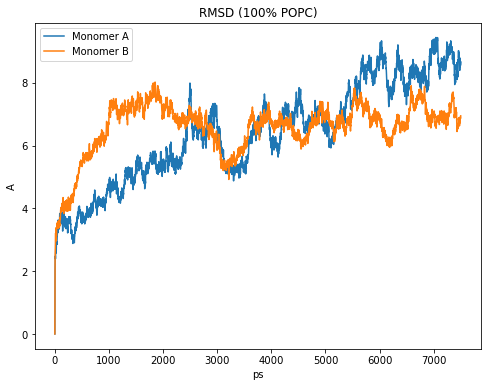

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(rmsd_df_NoC[::2], label=list(rmsd_df_NoC.columns))
ax.set_ylabel('A')
ax.set_xlabel('ps')
ax.legend(loc='best')
ax.set_title('RMSD (100% POPC)')


tikzplotlib.save('c:/Users/Ron/Desktop/UIUC/LabRotation1/tikz figs/'+'RMSD_comparison_POPC.tikz')


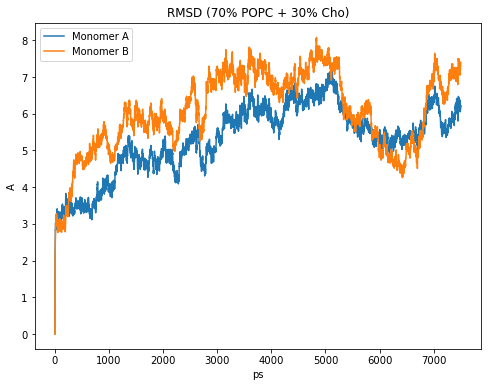

In [54]:
fig, ax = plt.subplots(1,1, figsize=(8,6))


ax.plot(rmsd_df_Cho[::2], label=list(rmsd_df_Cho.columns))
ax.set_ylabel('A')
ax.set_xlabel('ps')
ax.legend(loc='best')
ax.set_title('RMSD (70% POPC + 30% Cho)')

tikzplotlib.save('c:/Users/Ron/Desktop/UIUC/LabRotation1/tikz figs/'+'RMSD_comparison_CHO.tikz')


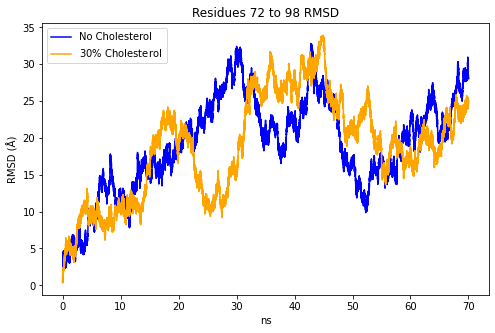

In [21]:
# Load the first dataset (No Cholesterol), skipping the header and filtering invalid entries
data1 = np.genfromtxt('trajrmsd_NoC.dat', skip_header=1, invalid_raise=False)
valid_data1 = data1[~np.isnan(data1[:, 1])]  # Filter out NA values
time_ps1 = valid_data1[:70000, 0]  # First 70000 rows, first column (frame or time)
rmsd_A1 = valid_data1[:70000, 1]   # First 70000 rows, second column (RMSD in Å)

# Load the second dataset (30% Cholesterol), skipping the header and filtering invalid entries
data2 = np.genfromtxt('trajrmsd_CHO.dat', skip_header=1, invalid_raise=False)
valid_data2 = data2[~np.isnan(data2[:, 1])]  # Filter out NA values
time_ps2 = valid_data2[:70000, 0]  # First 70000 rows, first column (frame or time)
rmsd_A2 = valid_data2[:70000, 1]   # First 70000 rows, second column (RMSD in Å)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot the first dataset (No Cholesterol)
plt.plot(time_ps1/1000, rmsd_A1, color='b', label='No Cholesterol')

# Plot the second dataset (30% Cholesterol)
plt.plot(time_ps2/1000, rmsd_A2, color='orange', label=r'$30\%$ Cholesterol')

# Label the axes
plt.xlabel('ns')
plt.ylabel('RMSD (Å)')

# Add a title and a legend
plt.title('Residues 72 to 98 RMSD')
plt.legend()


plt.savefig('c:/Users/Ron/Desktop/UIUC/LabRotation1/ReportFigures/'+'RMSD_70ns.png', dpi=300)
# Show the plot
plt.show()


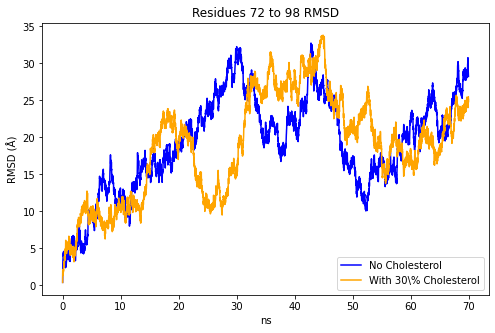

In [25]:
# Load the first dataset (No Cholesterol), skipping the header and filtering invalid entries
data1 = np.genfromtxt('trajrmsd_NoC.dat', skip_header=1, invalid_raise=False)
valid_data1 = data1[~np.isnan(data1[:, 1])]  # Filter out NA values
time_ps1 = valid_data1[:70000:10, 0]  # First 70000 rows, first column (frame or time)
rmsd_A1 = valid_data1[:70000:10, 1]   # First 70000 rows, second column (RMSD in Å)

# Load the second dataset (30% Cholesterol), skipping the header and filtering invalid entries
data2 = np.genfromtxt('trajrmsd_CHO.dat', skip_header=1, invalid_raise=False)
valid_data2 = data2[~np.isnan(data2[:, 1])]  # Filter out NA values
time_ps2 = valid_data2[:70000:10, 0]  # First 70000 rows, first column (frame or time)
rmsd_A2 = valid_data2[:70000:10, 1]   # First 70000 rows, second column (RMSD in Å)

# Create the plot
plt.figure(figsize=(8, 5))

# Plot the first dataset (No Cholesterol)
plt.plot(time_ps1/1000, rmsd_A1, color='b', label='No Cholesterol')

# Plot the second dataset (30% Cholesterol)
plt.plot(time_ps2/1000, rmsd_A2, color='orange', label=r'With 30\% Cholesterol')

# Label the axes
plt.xlabel('ns')
plt.ylabel('RMSD (Å)')

# Add a title and a legend
plt.title('Residues 72 to 98 RMSD')
plt.legend(loc=4)

tikzplotlib.save('c:/Users/Ron/Desktop/UIUC/LabRotation1/tikz figs/'+'RMSD_70ns.tikz')

# Show the plot
plt.show()



# Salt Bridge Analysis
Cutoff distance = 4.5 A

In [13]:
# def contacts_within_cutoff(u, group_a, group_b, radius=4.5): #determine number of contacts per frame in the trajectory
#     timeseries = []
#     for ts in u.trajectory:
#         # calculate distances between group_a and group_b
#         dist = contacts.distance_array(group_a.positions, group_b.positions)
#         # determine which distances <= radius
#         n_contacts = contacts.contact_matrix(dist, radius).sum()
#         timeseries.append([ts.frame, n_contacts])
#     return np.array(timeseries)

In [14]:
# sel_basic_chainA = "(resname ARG LYS) and (name NH* NZ) and (segid PROA)"
# sel_acidic_chainA = "(resname ASP GLU) and (name OE* OD*) and (segid PROA)"
# sel_acidic_chainB = "(resname ASP GLU) and (name OE* OD*) and (segid PROB)"
# sel_basic_chainB = "(resname ASP GLU) and (name OE* OD*) and (segid PROB)"
# acidicA = u.select_atoms(sel_acidic_chainA)
# acidicB = u.select_atoms(sel_acidic_chainB)
# basicB = u.select_atoms(sel_basic_chainB)
# basicA = u.select_atoms(sel_basic_chainA)

NameError: name 'u' is not defined

In [122]:
# ca = contacts_within_cutoff(u, acidicA, basicB, radius=4.5)
# ca2 = contacts_within_cutoff(u, acidicB, basicA, radius=4.5)


<AxesSubplot:title={'center':'Number of Interchain Salt Bridges'}, xlabel='Frame'>

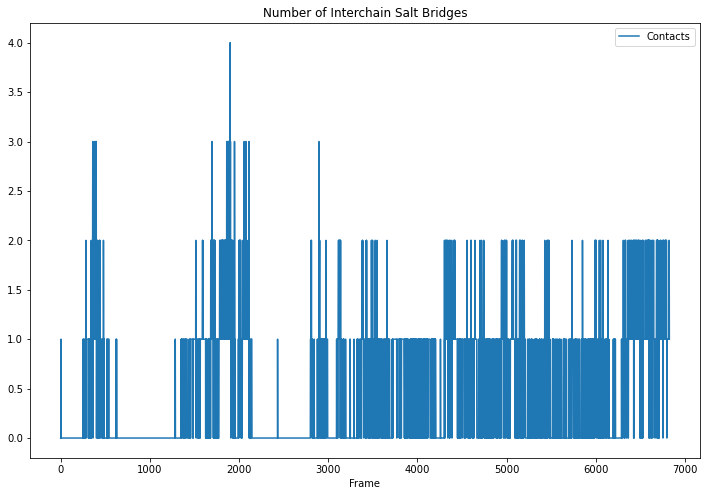

In [135]:
# total_ca=pd.DataFrame(ca, columns=['Frame', 'Contacts'])
# total_ca.head()
# total_ca.plot(x='Frame', title='Number of Interchain Salt Bridges', figsize=(12,8))

# Contact Analysis

In [26]:
def distance_matrix(A, B):
    # Expand A to Nx1x3 and B to 1xNx3 so broadcasting can be used
    A_exp = np.expand_dims(A, axis=1)
    B_exp = np.expand_dims(B, axis=0)
    
    # Compute the squared differences along the last dimension, then sum and take the square root
    dists = np.sqrt(np.sum((A_exp - B_exp) ** 2, axis=-1))
    
    return dists

def pairwise_diagonal_distances(proA_CA, proB_CA):
    return np.linalg.norm(proA_CA - proB_CA, axis=1)

Text(0.5, 1.0, 'Pairwise Residue Contacts (Reference Frame 0, 70% POPC + 30% CHO)')

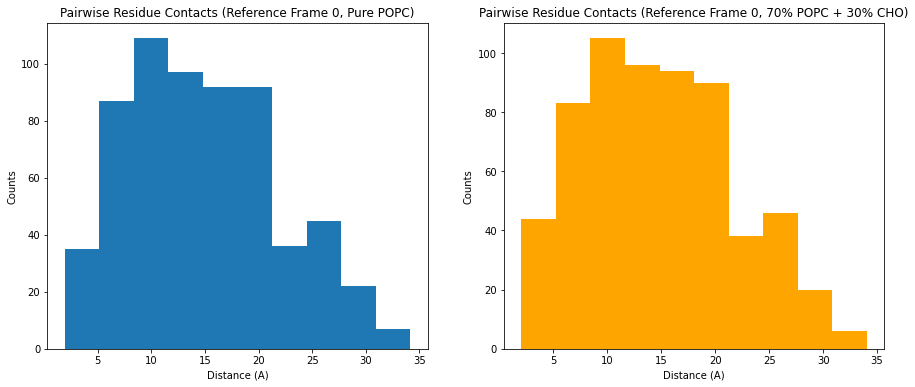

In [27]:
u_NoC.trajectory[0]
proA_NoC = u_NoC.select_atoms('segid PROA and protein')
proB_NoC = u_NoC.select_atoms('segid PROB and protein')
# Identify groups of contacting residues between monomers (chain A residue i and chain B residue i, pairwise)
D_NoC= distances.dist(proA_NoC, proB_NoC, offset=-61) 
cutoff_dist_indices_NoC = np.argwhere(D_NoC[2]<=5).flatten() #5A cutoff
chainA_NoC_res_filtered, chainB_NoC_res_filtered = D_NoC[0][cutoff_dist_indices_NoC], D_NoC[1][cutoff_dist_indices_NoC]


u_Cho.trajectory[0]
proA_Cho = u_Cho.select_atoms('segid PROA and protein')
proB_Cho = u_Cho.select_atoms('segid PROB and protein')
D_Cho= distances.dist(proA_Cho, proB_Cho, offset=-61) 
cutoff_dist_indices_Cho = np.argwhere(D_Cho[2]<=5).flatten() #5A cutoff
chainA_Cho_res_filtered, chainB_Cho_res_filtered = D_NoC[0][cutoff_dist_indices_Cho], D_NoC[1][cutoff_dist_indices_Cho]

fig, ax = plt.subplots(1,2, figsize=(15,6))

ax[0].hist(D_NoC[2])
ax[0].set_xlabel('Distance (A)')
ax[0].set_ylabel('Counts')
ax[0].set_title('Pairwise Residue Contacts (Reference Frame 0, Pure POPC)')

ax[1].hist(D_Cho[2], color='orange')
ax[1].set_xlabel('Distance (A)')
ax[1].set_ylabel('Counts')
ax[1].set_title('Pairwise Residue Contacts (Reference Frame 0, 70% POPC + 30% CHO)')


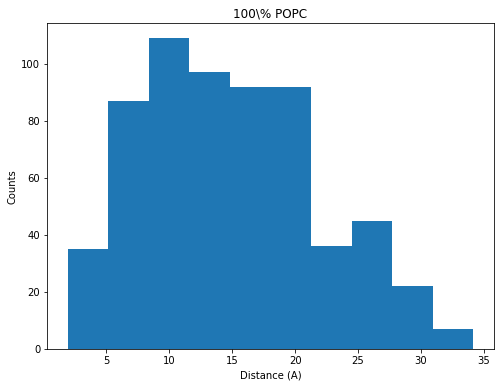

In [36]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.hist(D_NoC[2])
ax.set_xlabel('Distance (A)')
ax.set_ylabel('Counts')
ax.set_title('100\% POPC')

tikzplotlib.save('c:/Users/Ron/Desktop/UIUC/LabRotation1/tikz figs/Pairwise_Res_POPC.tikz')


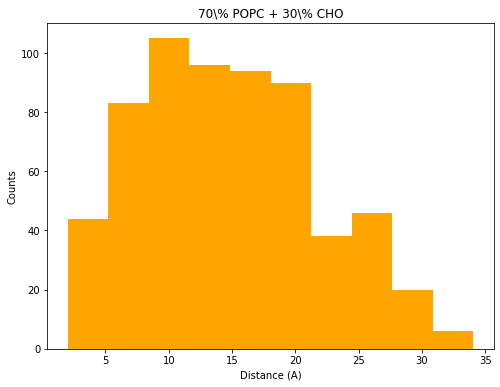

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.hist(D_Cho[2], color='orange')
ax.set_xlabel('Distance (A)')
ax.set_ylabel('Counts')
ax.set_title('70\% POPC + 30\% CHO')

tikzplotlib.save('c:/Users/Ron/Desktop/UIUC/LabRotation1/tikz figs/Pairwise_Res_CHO.tikz')

In [42]:
#Residues within 5A at frame 0

D_NoC= distances.dist(proA_NoC, proB_NoC, offset=-61) 
resid_string_NoC = ''
print('Residues within 5A for Pure POPC system')
for i in set(chainA_NoC_res_filtered):
    resid_string_NoC = resid_string_NoC + f' or resid {int(i)+61}'
    print(f'{u_NoC.residues[int(i)].resname}{int(i)+61}-{u_NoC.residues[int(i)].resname}{int(i)+61}')
resid_string_NoC=resid_string_NoC[4:]

D_Cho= distances.dist(proA_Cho, proB_Cho, offset=-61) 
resid_string_Cho = ''
print('Residues within 5A for 70% POPC + 30% CHO system')
for i in set(chainA_Cho_res_filtered):
    if int(i)+61 != 83:
        resid_string_Cho = resid_string_Cho + f' or resid {int(i)+61}'
    print(f'{u_Cho.residues[int(i)].resname}{int(i)+61}-{u_Cho.residues[int(i)].resname}{int(i)+61}')
resid_string_Cho=resid_string_Cho[4:]

Residues within 5A for Pure POPC system
ILE95-ILE95
GLU72-GLU72
LEU75-LEU75
ILE76-ILE76
GLY79-GLY79
VAL80-VAL80
VAL84-VAL84
THR87-THR87
ILE91-ILE91
Residues within 5A for 70% POPC + 30% CHO system
ILE95-ILE95
GLU72-GLU72
LEU75-LEU75
ILE76-ILE76
GLY79-GLY79
VAL80-VAL80
GLY83-GLY83
VAL84-VAL84
THR87-THR87
ILE91-ILE91


In [43]:
N=7500 #number of frames
dist_matrix_NoC = np.zeros((N,len(set(chainA_NoC_res_filtered)))) 
dist_matrix_Cho = np.zeros((N,len(set(chainA_Cho_res_filtered))-1)) #Remove Gly83 

selA_atoms_NoC = u_NoC.select_atoms(resid_string_NoC + ' and protein and name CA and segid PROA') 
selB_atoms_NoC = u_NoC.select_atoms(resid_string_NoC + ' and protein and name CA and segid PROB')

selA_atoms_Cho = u_Cho.select_atoms(resid_string_Cho + ' and protein and name CA and segid PROA')
selB_atoms_Cho = u_Cho.select_atoms(resid_string_Cho + ' and protein and name CA and segid PROB')

for frame in range(N):
    u_NoC.trajectory[frame]
    u_Cho.trajectory[frame]
    selA_coords_NoC = selA_atoms_NoC.positions
    selB_coords_NoC = selB_atoms_NoC.positions

    selA_coords_Cho = selA_atoms_Cho.positions
    selB_coords_Cho = selB_atoms_Cho.positions
    dist_matrix_NoC[frame] = pairwise_diagonal_distances(selA_coords_NoC, selB_coords_NoC)
    dist_matrix_Cho[frame] = pairwise_diagonal_distances(selA_coords_Cho, selB_coords_Cho)


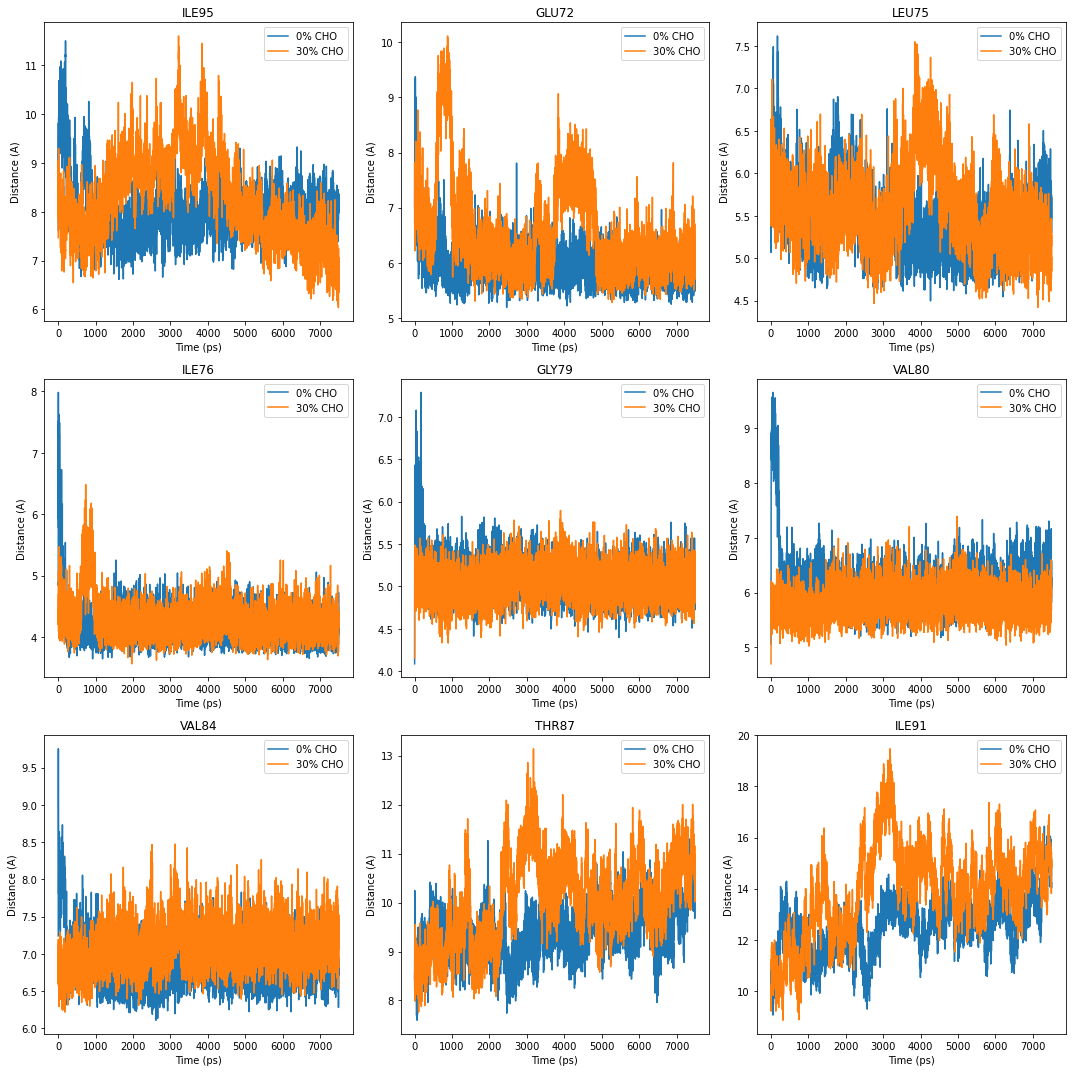

In [44]:
# Assuming dist_matrix is already calculated and converted into a DataFrame
dist_matrix_NoC_dataframe = pd.DataFrame(dist_matrix_NoC, columns=['ILE95', 'GLU72', 'LEU75', 'ILE76', 'GLY79', 'VAL80', 'VAL84', 'THR87', 'ILE91'])
dist_matrix_Cho_dataframe = pd.DataFrame(dist_matrix_Cho, columns=['ILE95', 'GLU72', 'LEU75', 'ILE76', 'GLY79', 'VAL80', 'VAL84', 'THR87', 'ILE91'])

# Create a grid of subplots (3 rows, 3 columns)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Flatten the 3x3 grid of axes for easy iteration
axes = axes.flatten()

# Plot each column of the DataFrame in its respective subplot
for i, column in enumerate(dist_matrix_NoC_dataframe.columns):
    axes[i].plot(dist_matrix_NoC_dataframe.index, dist_matrix_NoC_dataframe[column], label='0% CHO')
    axes[i].plot(dist_matrix_Cho_dataframe.index, dist_matrix_Cho_dataframe[column], label='30% CHO')
    axes[i].legend(loc='best')
    axes[i].set_title(column)  # Set the title to the column name
    axes[i].set_xlabel('Time (ps)')
    axes[i].set_ylabel('Distance (A)')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [45]:
# Define the output directory for saving the TikZ files
output_directory = 'c:/Users/Ron/Desktop/UIUC/LabRotation1/tikz_figs/'
os.makedirs(output_directory, exist_ok=True)

# Iterate over each column in the dataframe and create individual plots
for i, column in enumerate(dist_matrix_NoC_dataframe.columns):
    fig, ax = plt.subplots(figsize=(5, 5))  # Set figure size to 5x5 inches
    
    # Plot the data for NoC and Cho
    ax.plot(dist_matrix_NoC_dataframe.index, dist_matrix_NoC_dataframe[column], label='0% CHO')
    ax.plot(dist_matrix_Cho_dataframe.index, dist_matrix_Cho_dataframe[column], label='30% CHO')
    
    # Set labels and title
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('Distance (A)')
    ax.set_title(column)
    
    # Add legend
    ax.legend(loc='best')
    
    # Define the output file path, using the column name in the file name
    output_path = os.path.join(output_directory, f'Pairwise_Res_{column}.tikz')
    
    # Save the figure as a TikZ file
    tikzplotlib.save(output_path)
    
    # Close the figure to free up memory
    plt.close(fig)

print("All plots saved successfully!")

All plots saved successfully!


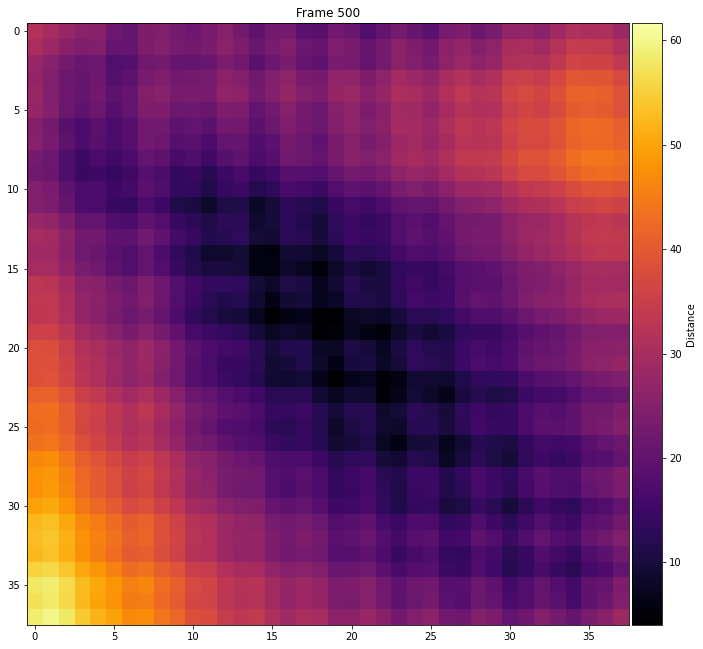

In [213]:
u.trajectory[0]
proA_CA = u.select_atoms('segid PROA and name CA').positions
proB_CA = u.select_atoms('segid PROB and name CA').positions

fig, ax = plt.subplots(figsize=(10, 10))

fig.patch.set_facecolor('white')  # Set figure background color to white
ax.set_facecolor('white')  # Set axes background color to white

initial_matrix = np.zeros_like(distance_matrix(proA_CA, proB_CA))
im = ax.imshow(initial_matrix, cmap='inferno')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Distance')

ax.set_title("Frame 1")
plt.tight_layout()

writer = PillowWriter(fps=30)
with writer.saving(fig, 'dimerContacts_500ps.gif', dpi=90):
    plt.tight_layout()
    for frame_number in range(500):
        u.trajectory[frame_number]
        proA_CA = u.select_atoms('segid PROA and name CA').positions
        proB_CA = u.select_atoms('segid PROB and name CA').positions
        dist_matrix = distance_matrix(proA_CA, proB_CA)
        im.set_data(dist_matrix)
        im.set_clim(vmin=vmin, vmax=vmax)
        ax.set_title(f"Frame {frame_number + 1:03d}")
        plt.tight_layout()
        writer.grab_frame()
        
plt.show()